In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# 让图形在 Jupyter Notebook 中内嵌显示
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import random
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# 打印当前 Python 版本信息
print(sys.version_info)

# 打印使用库的版本信息
for module in mpl, np, pd, sklearn, torch :
    print(module.__name__, module.__version__)

# 设置 PyTorch 计算设备
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# 设置随机种子，以保证实验的可复现性
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu118
cuda:0


## 数据预处理

### 截取数据集

In [3]:
!python Intercept_dataset_row.py

### 划分数据集

In [4]:
# !python dataset_splitter.py

# 目标文件夹
output_dir = "./train_mixed_data_size_1410000"

# 输入文件
src_file = f"{output_dir}/UNv1.0.en-zh.en"
tgt_file = f"{output_dir}/UNv1.0.en-zh.zh"

# 输出文件路径
train_src, train_tgt = f"{output_dir}/train.en", f"{output_dir}/train.zh"
val_src, val_tgt = f"{output_dir}/val.en", f"{output_dir}/val.zh"
test_src, test_tgt = f"{output_dir}/test.en", f"{output_dir}/test.zh"

# 读取所有行
with open(src_file, "r", encoding="utf-8") as f_src, open(tgt_file, "r", encoding="utf-8") as f_tgt:
    src_lines = f_src.readlines()
    tgt_lines = f_tgt.readlines()

# 确保行数一致
assert len(src_lines) == len(tgt_lines), "行数不匹配！"

data = list(zip(src_lines, tgt_lines))

# 划分 95% 训练，2.5% 验证，2.5% 测试
total_size = len(data)
train_size = int(total_size * 0.95)
val_size = int(total_size * 0.025)

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# 保存数据
def save_data(file, dataset, idx):
    with open(file, "w", encoding="utf-8") as f:
        # 使用 tqdm 显示进度条
        for line in tqdm(dataset, desc=f"Saving {file}", unit="line"):
            f.write(line[idx])  # idx=0: en, idx=1: zh

save_data(train_src, train_data, 0)
save_data(train_tgt, train_data, 1)
save_data(val_src, val_data, 0)
save_data(val_tgt, val_data, 1)
save_data(test_src, test_data, 0)
save_data(test_tgt, test_data, 1)

print(f"数据集拆分完成，所有文件已保存到 {output_dir} 目录！")

### Moses&Jieba 分词

In [5]:
import os
from tqdm import tqdm
import jieba
from sacremoses import MosesTokenizer
from pathlib import Path
import subprocess

# 配置目录路径
pair_dir = Path("./train_data_size_1000000")  # 双语数据目录
dest_dir = Path("./train_data_size_1000000_cut")  # 分词结果目录

def moses_cut(in_file, out_file, lang):
    """
    使用 MosesTokenizer 对输入文件的文本进行分词，并将分词后的结果保存到输出文件中。
    """
    mt = MosesTokenizer(lang=lang)
    with open(out_file, "w", encoding="utf8") as out_f, open(in_file, "r", encoding="utf8") as f:
        lines = f.readlines()
        # 使用 tqdm 来显示处理进度
        for line in tqdm(lines, desc=f"Moses tokenizing {in_file.name}", unit="line"):
            line = line.strip()
            if line:
                cut_line = mt.tokenize(line, return_str=True)
                out_f.write(cut_line.lower() + "\n")

def jieba_cut(in_file, out_file):
    """
    使用 Jieba 对输入文件的文本进行分词，并将分词后的结果保存到输出文件中。
    """
    with open(out_file, "w", encoding="utf8") as out_f, open(in_file, "r", encoding="utf8") as f:
        lines = f.readlines()
        # 使用 tqdm 来显示处理进度
        for line in tqdm(lines, desc=f"Jieba tokenizing {in_file.name}", unit="line"):
            line = line.strip()
            if line:
                cut_line = " ".join(jieba.cut(line))
                out_f.write(cut_line + "\n")

# 主程序
if __name__ == "__main__":
    # 检查目标目录是否存在，如果没有则创建
    dest_dir.mkdir(parents=True, exist_ok=True)

    # 获取语言对文件所在的目录路径
    local_data_path = pair_dir
    data_dir = dest_dir

    # 遍历 ['train', 'val', 'test'] 三个数据集模式，分别进行分词处理
    for mode in ["train", "val", "test"]:
        # 对源语言文本进行 Moses 分词处理
        moses_cut(
            local_data_path / f"{mode}.en",  # 英文源语言
            data_dir / f"{mode}_src.cut.txt",
            lang="en"
        )
        print(f"[{mode}] English text tokenization completed")

        # 对目标语言文本进行 Jieba 分词处理
        jieba_cut(
            local_data_path / f"{mode}.zh",  # 中文目标语言
            data_dir / f"{mode}_trg.cut.txt"
        )
        print(f"[{mode}] Chinese text tokenization completed")

    print("Preprocessing completed.")

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# 设置字体与风格（适配中文）
plt.rcParams['font.family'] = 'Times New Roman'
sns.set(style="whitegrid")

# 载入数据函数
def load_dataset(en_file, zh_file, max_lines=20000):
    with open(en_file, encoding="utf-8") as f_en, open(zh_file, encoding="utf-8") as f_zh:
        en_lines = f_en.readlines()
        zh_lines = f_zh.readlines()
    assert len(en_lines) == len(zh_lines), "中英文句子数不一致"
    return en_lines[:max_lines], zh_lines[:max_lines]  # 限制最大样本数防止过慢

# 加载数据
en_lines, zh_lines = load_dataset(
    "./train_mixed_data_size_1410000/train.en",
    "./train_mixed_data_size_1410000/train.zh"
)

# 构造 DataFrame
df = pd.DataFrame({
    "en_length": [len(line.strip().split()) for line in en_lines],
    "zh_length": [len(line.strip()) for line in zh_lines],  # 中文按字符
})

# =====================
# 可视化 1：句长分布对比
# =====================
plt.figure(figsize=(10, 5))
sns.histplot(df["en_length"], color="blue", label="English (word count)", kde=True, bins=50)
sns.histplot(df["zh_length"], color="red", label="中文（字符数）", kde=True, bins=50)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("中英文句长分布对比")
plt.legend()
plt.tight_layout()
plt.savefig("sentence_length_distribution.png", dpi=300)
plt.show()

# =====================
# 可视化 2：中英文长度关系散点图
# =====================
plt.figure(figsize=(8, 6))
sns.scatterplot(x="en_length", y="zh_length", data=df, alpha=0.3)
plt.xlabel("English sentence length (word)")
plt.ylabel("Chinese sentence length (char)")
plt.title("中英文句长对应关系")
plt.grid(True)
plt.tight_layout()
plt.savefig("length_scatter.png", dpi=300)
plt.show()

# =====================
# 可视化 3：长度比（zh/en）分布
# =====================
df["length_ratio"] = df["zh_length"] / df["en_length"]
plt.figure(figsize=(10, 5))
sns.histplot(df["length_ratio"], bins=50, kde=True, color="green")
plt.xlabel("Length Ratio (zh_len / en_len)")
plt.title("中英文长度比率分布")
plt.tight_layout()
plt.savefig("length_ratio_distribution.png", dpi=300)
plt.show()

### BPE 分词

In [7]:
!sh double_vocab_bpe_process.sh ./train_data_size_1000000 ./train_data_size_1000000_cut

## DataLoader准备
### LangPairDataset

In [8]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
dataset_path = "./train_data_size_1000000"

class LangPairDataset(Dataset):
    """
    加载和处理双语数据集，并支持数据缓存。
    """
    def __init__(self, mode="train", max_length=128, overwrite_cache=False, data_dir=dataset_path):
        """
        初始化数据集。
        :param mode: 数据集模式（"train" 或 "val"）
        :param max_length: 句子最大长度，超过则过滤
        :param overwrite_cache: 是否覆盖缓存，默认为 False
        :param data_dir: 数据目录
        """
        self.data_dir = Path(data_dir)  # 数据存储路径
        cache_path = self.data_dir / ".cache" / f"de2en_{mode}_{max_length}.npy"  # 缓存路径

        if overwrite_cache or not cache_path.exists():  # 覆盖缓存或缓存不存在时重新处理
            cache_path.parent.mkdir(parents=True, exist_ok=True)  # 创建缓存目录

            # 读取源语言和目标语言文件
            with open(self.data_dir / f"{mode}_src.bpe", "r", encoding="utf8") as file:
                self.src = file.readlines()

            with open(self.data_dir / f"{mode}_trg.bpe", "r", encoding="utf8") as file:
                self.trg = file.readlines()

            filtered_src, filtered_trg = [], []  # 存放过滤后的句子

            # 过滤句子长度
            for src, trg in zip(self.src, self.trg):
                if len(src) <= max_length and len(trg) <= max_length:
                    filtered_src.append(src.strip())  # 去除首尾空格
                    filtered_trg.append(trg.strip())

            # 保存为 NumPy 数组并缓存
            np.save(cache_path, {"src": np.array(filtered_src), "trg": np.array(filtered_trg)}, allow_pickle=True)
            print(f"save cache to {cache_path}")

        else:  # 加载已有缓存
            cache_dict = np.load(cache_path, allow_pickle=True).item()
            print(f"load {mode} dataset from {cache_path}")
            filtered_src = cache_dict["src"]
            filtered_trg = cache_dict["trg"]

        self.src = filtered_src  # 源语言数据
        self.trg = filtered_trg  # 目标语言数据

    def __getitem__(self, index):
        """
        获取指定索引的源语言和目标语言句子。
        """
        return self.src[index], self.trg[index]

    def __len__(self):
        """
        返回数据集大小。
        """
        return len(self.src)

# 创建训练集和验证集对象
train_ds = LangPairDataset("train")
val_ds = LangPairDataset("val")

load train dataset from train_data_size_1000000\.cache\de2en_train_128.npy
load val dataset from train_data_size_1000000\.cache\de2en_val_128.npy


In [9]:
# 例子：查看数据集大小
print(len(train_ds))
print(len(val_ds))
for i in range(2):
    print("source: {}\ntarget: {}".format(*train_ds[i]))
    print("-"*50)

442260
10613
source: resolution 918 ( 1994 )
target: 第 918 ( 1994 ) 号 决议
--------------------------------------------------
source: adopted by the security council at its 3@@ 37@@ 7th meeting , on 17 may 1994
target: 1994 年 5 月 17 日 安全 理事会 第 3@@ 377 次 会议 通过
--------------------------------------------------


 ### Tokenizer

In [10]:
# 构建英文和中文的word2idx和idx2word字典
en_word2idx = {
    "[PAD]": 0,
    "[BOS]": 1,
    "[UNK]": 2,
    "[EOS]": 3,
}
zh_word2idx = {
    "[PAD]": 0,
    "[BOS]": 1,
    "[UNK]": 2,
    "[EOS]": 3,
}

# 反向索引
en_idx2word = {value: key for key, value in en_word2idx.items()}
zh_idx2word = {value: key for key, value in zh_word2idx.items()}

# 分别加载英文和中文词表
en_index = len(en_idx2word)
zh_index = len(zh_idx2word)
threshold = 1

# 读取英文词表
with open(f"{dataset_path}/en.vocab", "r", encoding="utf8") as file:
    for line in tqdm(file.readlines()):
        token, counts = line.strip().split()
        if int(counts) >= threshold:
            en_word2idx[token] = en_index
            en_idx2word[en_index] = token
            en_index += 1

# 读取中文词表
with open(f"{dataset_path}/zh.vocab", "r", encoding="utf8") as file:
    for line in tqdm(file.readlines()):
        token, counts = line.strip().split()
        if int(counts) >= threshold:
            zh_word2idx[token] = zh_index
            zh_idx2word[zh_index] = token
            zh_index += 1

  0%|          | 0/47609 [00:00<?, ?it/s]

  0%|          | 0/54986 [00:00<?, ?it/s]

In [11]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=128, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        """
        初始化 Tokenizer。
        :param word2idx: 单词到索引的映射
        :param idx2word: 索引到单词的映射
        :param max_length: 最大句子长度，超出则截断
        :param pad_idx: 填充 token 索引
        :param bos_idx: 句子起始 token 索引
        :param eos_idx: 句子结束 token 索引
        :param unk_idx: 未知单词索引
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """
        将文本列表编码为索引列表。
        :param text_list: 文本列表，每个元素是一个单词列表
        :param padding_first: 是否将 [PAD] 填充到句首
        :param add_bos: 是否添加 [BOS] 起始符号
        :param add_eos: 是否添加 [EOS] 结束符号
        :param return_mask: 是否返回 mask
        :return: 编码后的 input_ids 或 (input_ids, masks)
        """
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))
        indices_list = []

        for text in text_list:
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]
            if add_bos: indices = [self.bos_idx] + indices
            if add_eos: indices = indices + [self.eos_idx]

            # 填充到 max_length
            if padding_first:
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))

            indices_list.append(indices)

        input_ids = torch.tensor(indices_list) # 转换为 tensor
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64)  # 生成 mask，标记 padding 部分

        return input_ids if not return_mask else (input_ids, masks)

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """
        解码索引列表为文本列表。
        :param indices_list: 索引列表
        :param remove_bos: 是否移除 [BOS]
        :param remove_eos: 是否移除 [EOS]
        :param remove_pad: 是否移除 [PAD]
        :param split: 是否返回分词列表
        :return: 解码后的文本列表
        """
        text_list = []

        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")  # 获取单词
                if remove_bos and word == "[BOS]": continue
                if remove_eos and word == "[EOS]": break
                if remove_pad and word == "[PAD]": break
                text.append(word)

            text_list.append(" ".join(text) if not split else text)

        return text_list

In [12]:
# 创建英文和中文的tokenizer
en_tokenizer = Tokenizer(word2idx=en_word2idx, idx2word=en_idx2word)
zh_tokenizer = Tokenizer(word2idx=zh_word2idx, idx2word=zh_idx2word)

# 输出词表大小
en_vocab_size = len(en_word2idx)
zh_vocab_size = len(zh_word2idx)
print("en_vocab_size: {}".format(en_vocab_size))  # 打印英文词表大小
print("zh_vocab_size: {}".format(zh_vocab_size))  # 打印中文词表大小

en_vocab_size: 47613
zh_vocab_size: 54990


### Transformer Batch Sampler

In [13]:
class SampleInfo:
    def __init__(self, i, lens):
        """
        记录文本对的序号和长度信息。

        :param i: 文本对的序号。
        :param lens: 文本对的长度，包含源语言和目标语言的长度。
        """
        self.i = i
        # 加一是为了考虑填充的特殊词元，lens[0] 和 lens[1] 分别表示源语言和目标语言的长度
        self.max_len = max(lens[0], lens[1]) + 1
        self.src_len = lens[0] + 1
        self.trg_len = lens[1] + 1


class TokenBatchCreator:
    def __init__(self, batch_size):
        """
        根据词元数目限制批量大小，并初始化批量存储结构。

        :param batch_size: 批量的最大大小。
        """
        self._batch = []  # 当前处理的样本
        self.max_len = -1  # 当前批量的最大长度
        self._batch_size = batch_size  # 批量大小限制

    def append(self, info: SampleInfo):
        """
        将样本信息添加到批量中。如果当前批量大小超过限制，则返回当前批量并创建新批量。

        :param info: 包含文本对长度信息的 SampleInfo 对象。
        :return: 当前批量样本，如果超过限制，则返回并重置批量，否则返回 None。
        """
        cur_len = info.max_len  # 当前样本的最大长度
        max_len = max(self.max_len, cur_len)  # 更新当前批量的最大长度

        # 如果当前批量加入新样本后超过限制，返回当前批量并重置
        if max_len * (len(self._batch) + 1) > self._batch_size:
            self._batch, result = [], self._batch  # 保存当前样本并清空
            self._batch.append(info)  # 新批量的第一条样本
            self.max_len = cur_len  # 当前批量的最大长度为新样本的最大长度
            return result
        else:
            self.max_len = max_len
            self._batch.append(info)  # 将新样本加入当前批量
            return None

    @property
    def batch(self):
        return self._batch

In [14]:
from torch.utils.data import BatchSampler
import numpy as np

class TransformerBatchSampler(BatchSampler):
    def __init__(self,
                 dataset,
                 batch_size,
                 shuffle_batch=False,
                 clip_last_batch=False,
                 seed=0):
        """
        批量采样器，用于按批次生成样本。

        :param dataset: 数据集
        :param batch_size: 每个批次的样本数量
        :param shuffle_batch: 是否对批次进行洗牌
        :param clip_last_batch: 是否裁剪最后一个批次的数据（如果样本数不足一个完整批次）
        :param seed: 随机数种子，用于保证可重复性
        """
        self._dataset = dataset
        self._batch_size = batch_size
        self._shuffle_batch = shuffle_batch
        self._clip_last_batch = clip_last_batch
        self._seed = seed
        self._random = np.random
        self._random.seed(seed)

        self._sample_infos = []
        # 创建样本信息列表，包含每个样本的索引和长度信息
        for i, data in enumerate(self._dataset):
            lens = [len(data[0]), len(data[1])]  # 计算样本的源语言和目标语言的长度
            self._sample_infos.append(SampleInfo(i, lens)) # 保存为 [索引，样本长度]的格式

    def __iter__(self):
        """
        对数据集中的样本进行排序，并使用 TokenBatchCreator 生成批次。

        排序规则：先按源语言长度排序，若源语言长度相同，再按目标语言长度排序。
        生成的批次如果未裁剪最后一批，则将剩余样本组成最后一个批次。
        如果需要洗牌，则对批次进行洗牌。

        :yield: 每个批次的样本在数据集中的索引
        """
        # 按源语言和目标语言长度排序
        infos = sorted(self._sample_infos, key=lambda x: (x.src_len, x.trg_len))
        batch_infos = []
        batch_creator = TokenBatchCreator(self._batch_size)  # 批量生成器

        # 逐个样本加入批量生成器
        for info in infos:
            batch = batch_creator.append(info)
            if batch is not None:
                batch_infos.append(batch)  # 每当批次满足要求时，保存当前批次

        # 如果未裁剪最后一个批次且有剩余样本，则将剩余样本作为最后一个批次
        if not self._clip_last_batch and len(batch_creator.batch) != 0:
            batch_infos.append(batch_creator.batch)

        # 打乱批次顺序
        if self._shuffle_batch:
            self._random.shuffle(batch_infos)

        # 记录批次数量
        self.batch_number = len(batch_infos)

        # 生成批次中的样本索引
        for batch in batch_infos:
            batch_indices = [info.i for info in batch]  # 获取当前批次的样本索引
            yield batch_indices

    def __len__(self):
        """
        返回批次数量
        """
        if hasattr(self, "batch_number"):
            return self.batch_number

        # 如果没有记录批次数量，计算批次样本数量
        batch_number = (len(self._dataset) + self._batch_size - 1) // self._batch_size
        return batch_number

In [15]:
# 创建一个 TransformerBatchSampler 实例，用于从训练数据集 train_ds 中按批次采样样本
sampler = TransformerBatchSampler(
    train_ds,  # 训练数据集，包含源语言和目标语言的样本
    batch_size=4096,  # 每个批次包含的样本数量，设定为 4096
    shuffle_batch=True  # 是否对批次进行洗牌，设定为 True，即每次迭代时都会打乱批次顺序
)
# 例子： 打印一个批次的样本索引
for idx, batch in enumerate(sampler):
    print("第{}批量的数据中含有文本对的索引是：{}，当前批次样本数量为：{}".format(idx, batch, len(batch)))
    break
for i in batch:
    print(f"{i}: {train_ds[i]}\n");
total_len = 0;

第0批量的数据中含有文本对的索引是：[177123, 181145, 183738, 183749, 196027, 200451, 201039, 202773, 209891, 211089, 211265, 211720, 212103, 214300, 214886, 216353, 228949, 228997, 238540, 239016, 246146, 246779, 247191, 260622, 264130, 265094, 267169, 270118, 270555, 271227, 274483, 276661, 285138, 301826, 303258, 307481, 308495, 310434, 311234, 324467, 330292, 332631, 332738, 337111, 343421, 346577, 347080, 351876, 359508, 362942, 364388, 364566, 365230, 365519, 371174, 372653, 378024, 378198, 380807, 381646, 388110, 390237, 392897, 394330, 395382, 396599, 396721, 412544, 416351, 419822, 421330, 423834, 433976, 440247, 441533, 441984, 6064, 6296, 7812, 11332, 11753, 14298, 15477, 17214, 18055]，当前批次样本数量为：85
177123: (np.str_('elimination of racism and racial discrimination'), np.str_('消除 种族主义 和 种族歧视'))

181145: (np.str_('elimination of racism and racial discrimination'), np.str_('消除 种族主义 和 种族歧视'))

183738: (np.str_('benefiting from the multilateral trading system'), np.str_('从 多边贸易 体系 中 获益'))

183749: (

### DataLoader

In [16]:
from functools import partial # 固定collate_fct的tokenizer参数
def collate_fct(batch, en_tokenizer, zh_tokenizer):
    # 分别对源语言(英文)和目标语言(中文)进行处理
    src_words = [pair[0].split() for pair in batch]
    trg_words = [pair[1].split() for pair in batch]

    # 使用英文tokenizer处理源语言
    encoder_inputs, encoder_inputs_mask = en_tokenizer.encode(
        src_words, padding_first=False, add_bos=True, add_eos=True, return_mask=True
    )

    # 使用中文tokenizer处理目标语言
    decoder_inputs = zh_tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
    )

    decoder_labels, decoder_labels_mask = zh_tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
    )

    return {
        "encoder_inputs": encoder_inputs.to(device=device),
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),
        "decoder_inputs": decoder_inputs.to(device=device),
        "decoder_labels": decoder_labels.to(device=device),
        "decoder_labels_mask": decoder_labels_mask.to(device=device),
    }

In [17]:
# 例子：查看编码后的批次数据
#可以调大batch_size,来看最终的bleu，如果GPU内存不够，可以减小batch_size
sampler = TransformerBatchSampler(train_ds, batch_size=256, shuffle_batch=True)
#partial函数，固定collate_fct的tokenizer参数
sample_dl = DataLoader(train_ds, batch_sampler=sampler, collate_fn=partial(collate_fct, en_tokenizer=en_tokenizer, zh_tokenizer=zh_tokenizer))

for batch in sample_dl:#外层是拿每个batch
    for key, value in batch.items():#内层是拿每个batch里面是一个字典
        print(key)
        print(value)
        print(value.shape)
    break

encoder_inputs
tensor([[   1, 1027,    7,  349, 1194, 4191,    4,  662,    5,   77, 1795,    8,
         4865,   10,    4,  364,    7,    3],
        [   1,  117,  220,  709,   16,   54,  580,    8,  146,   43, 1748,   16,
         2745,   21,  147,    7,    3,    0]], device='cuda:0')
torch.Size([2, 18])
encoder_inputs_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]],
       device='cuda:0')
torch.Size([2, 18])
decoder_inputs
tensor([[   1,  854,   11,   68,  134,   27,   75,    7,  236, 2990,    4, 1249,
            4,  250,   17, 1062, 1203,  676,    5],
        [   1,   44,   62,  162,   70,    8,   63,    4,  771,    7, 1785,   88,
          164,  287,  573,  279, 2442,    5,    0]], device='cuda:0')
torch.Size([2, 19])
decoder_labels
tensor([[ 854,   11,   68,  134,   27,   75,    7,  236, 2990,    4, 1249,    4,
          250,   17, 1062, 1203,  676,    5,    3],
        [  44,   62,  162,   70, 

## 定义模型

### Embedding

In [18]:
class TransformerEmbedding(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        # 获取配置中的超参数
        self.vocab_size = vocab_size
        self.hidden_size = config["d_model"]
        self.pad_idx = config["pad_idx"]
        dropout_rate = config["dropout"]
        self.max_length = config["max_length"]

        # 词嵌入层，padding_idx为pad的索引
        self.word_embedding = nn.Embedding(self.vocab_size, self.hidden_size, padding_idx=self.pad_idx)
        # 位置嵌入层，权重由get_positional_encoding计算得到
        self.pos_embedding = nn.Embedding(
            self.max_length,
            self.hidden_size,
            _weight=self.get_positional_encoding(self.max_length, self.hidden_size)
        )
        self.pos_embedding.weight.requires_grad_(False)  # 位置编码不可训练
        self.dropout = nn.Dropout(dropout_rate)  # Dropout层

    def get_word_embedding_weights(self):
        # 返回词嵌入层的权重
        return self.word_embedding.weight

    @classmethod
    def get_positional_encoding(self, max_length, hidden_size):
        """
        计算位置编码
        使用正弦和余弦函数生成位置编码矩阵
        """
        pe = torch.zeros(max_length, hidden_size)
        position = torch.arange(0, max_length).unsqueeze(1)  # 位置索引
        div_term = torch.exp(
            torch.arange(0, hidden_size, 2) * -(torch.log(torch.Tensor([10000.0])) / hidden_size)
        )
        # 填充位置编码矩阵
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数列为sin
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数列为cos
        return pe

    def forward(self, input_ids):
        """
        前向传播：词向量与位置编码加和
        """
        seq_len = input_ids.shape[1]  # 序列长度
        assert seq_len <= self.max_length, f"序列长度超出最大限制 {self.max_length}"

        # 生成位置id
        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device) # [seq_len]
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)  # [batch_size, seq_len]

        # 获取词嵌入和位置编码
        word_embeds = self.word_embedding(input_ids) # [batch_size, seq_len, hidden_size]
        pos_embeds = self.pos_embedding(position_ids) # [batch_size, seq_len, hidden_size]
        embeds = word_embeds + pos_embeds  # 加和词向量和位置编码
        embeds = self.dropout(embeds)  # 应用dropout
        return embeds  # [batch_size, seq_len, hidden_size]


def plot_position_embedding(position_embedding):
    """
    绘制位置编码矩阵
    """
    plt.pcolormesh(position_embedding)  # 绘制矩阵
    plt.xlabel('Depth')  # x轴为深度
    plt.ylabel('Position')  # y轴为位置
    plt.colorbar()  # 显示颜色条
    plt.show()  # 显示图像

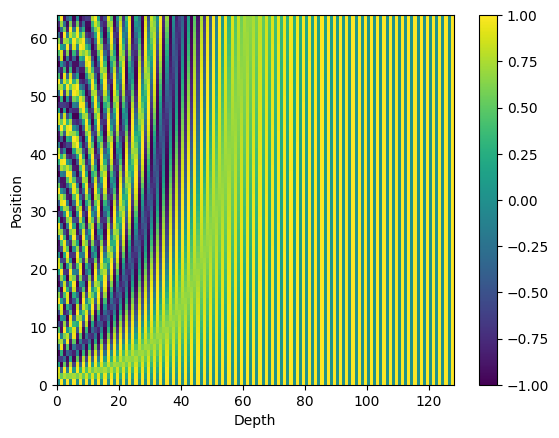

In [19]:
# 例子：获取64个位置、128维词向量的位置编码矩阵并绘制
position_embedding = TransformerEmbedding.get_positional_encoding(64, 128)
plot_position_embedding(position_embedding)

### Transformer

#### Scaled Dot Product Attention

In [20]:
from dataclasses import dataclass
from typing import Optional, Tuple

Tensor = torch.Tensor

@dataclass
class AttentionOutput:
    hidden_states: Tensor  # 注意力层的最终输出
    attn_scores: Tensor    # 计算得到的注意力权重

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 获取配置中的超参数
        self.hidden_size = config["d_model"]
        self.num_heads = config["num_heads"]

        # 确保 hidden_size 可以被 num_heads 整除
        assert self.hidden_size % self.num_heads == 0, "Hidden size must be divisible by num_heads"

        self.head_dim = self.hidden_size // self.num_heads  # 每个头的维度

        # 定义线性变换层
        self.Wq = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wk = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wv = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wo = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

    def _split_heads(self, x: Tensor) -> Tensor:
        """
        将输入张量拆分为多个头
        """
        bs, seq_len, _ = x.shape
        x = x.view(bs, seq_len, self.num_heads, self.head_dim)  # 调整形状
        return x.permute(0, 2, 1, 3)  # 调整维度顺序

    def _merge_heads(self, x: Tensor) -> Tensor:
        """
        合并多个头的输出
        """
        bs, _, seq_len, _ = x.shape
        return x.permute(0, 2, 1, 3).reshape(bs, seq_len, self.hidden_size)

    def forward(self, querys, keys, values, attn_mask=None) -> AttentionOutput:
        """
        前向传播计算注意力机制
        """
        # 线性变换并拆分为多个头
        querys = self._split_heads(self.Wq(querys))  # [batch_size, num_heads, seq_len, head_dim]
        keys = self._split_heads(self.Wk(keys))      # [batch_size, num_heads, seq_len, head_dim]
        values = self._split_heads(self.Wv(values))  # [batch_size, num_heads, seq_len, head_dim]

        # 计算 Q 和 K 之间的点积注意力分数
        qk_logits = torch.matmul(querys, keys.mT)  # [batch_size, num_heads, seq_len, seq_len]

        # 如果提供了mask，应用它
        if attn_mask is not None:
            attn_mask = attn_mask[:, :, : querys.shape[-2], : keys.shape[-2]]  # 调整mask的大小
            qk_logits += attn_mask * -1e9  # mask部分置为负无穷

        # 计算注意力权重
        attn_scores = F.softmax(qk_logits / (self.head_dim**0.5), dim=-1)  # [batch_size, num_heads, seq_len, seq_len]

        # 加权求和
        embeds = torch.matmul(attn_scores, values)  # [batch_size, num_heads, seq_len, head_dim]

        # 合并头的输出并通过输出投影层
        embeds = self.Wo(self._merge_heads(embeds))  # [batch_size, seq_len, hidden_size]

        return AttentionOutput(hidden_states=embeds, attn_scores=attn_scores)

#### Transformer Block

In [21]:
@dataclass
class TransformerBlockOutput:
    # 当前块的输出（隐藏状态）和自/交叉注意力的分数
    hidden_states: Tensor
    self_attn_scores: Tensor
    cross_attn_scores: Optional[Tensor] = None

class TransformerBlock(nn.Module):
    def __init__(self, config, add_cross_attention=False):
        super().__init__()

        # 获取配置中的超参数
        self.hidden_size = config["d_model"]
        self.num_heads = config["num_heads"]
        dropout_rate = config["dropout"]
        ffn_dim = config["dim_feedforward"]
        eps = config["layer_norm_eps"]

        # 自注意力机制
        self.self_atten = MultiHeadAttention(config)
        self.self_ln = nn.LayerNorm(self.hidden_size, eps=eps)
        self.self_dropout = nn.Dropout(dropout_rate)

        # 交叉注意力机制（仅解码器中使用）
        if add_cross_attention:
            self.cross_atten = MultiHeadAttention(config)
            self.cross_ln = nn.LayerNorm(self.hidden_size, eps=eps)
            self.cross_dropout = nn.Dropout(dropout_rate)
        else:
            self.cross_atten = None

        # 前馈神经网络（FFN）
        self.ffn = nn.Sequential(
            nn.Linear(self.hidden_size, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, self.hidden_size),
        )
        self.ffn_ln = nn.LayerNorm(self.hidden_size, eps=eps)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, hidden_states, attn_mask=None, encoder_outputs=None, cross_attn_mask=None):
        # 自注意力机制
        self_atten_output = self.self_atten(
            hidden_states, hidden_states, hidden_states, attn_mask
        )
        self_embeds = self.self_ln(
            hidden_states + self.self_dropout(self_atten_output.hidden_states)
        )

        # 交叉注意力机制（解码器中）
        if self.cross_atten is not None:
            assert encoder_outputs is not None  # 使用交叉注意力时，必须传入编码器输出
            cross_atten_output = self.cross_atten(
                self_embeds, encoder_outputs, encoder_outputs, cross_attn_mask
            )
            cross_embeds = self.cross_ln(
                self_embeds + self.cross_dropout(cross_atten_output.hidden_states)
            )

        # 前馈神经网络（FFN）
        embeds = cross_embeds if self.cross_atten is not None else self_embeds
        ffn_output = self.ffn(embeds)
        embeds = self.ffn_ln(embeds + self.ffn_dropout(ffn_output))

        # 返回 TransformerBlockOutput
        return TransformerBlockOutput(
            hidden_states=embeds,
            self_attn_scores=self_atten_output.attn_scores,
            cross_attn_scores=cross_atten_output.attn_scores if self.cross_atten is not None else None,
        )

#### Encoder

In [22]:
from typing import List

@dataclass  # 存储TransformerEncoder的输出
class TransformerEncoderOutput:
    last_hidden_states: Tensor  # 最后一层的隐藏状态，包含上下文信息
    attn_scores: List[Tensor]   # 每层的注意力分数，用于分析每层的关注点

class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        # 获取编码器层数
        self.num_layers = config["num_encoder_layers"]

        # 创建包含多个TransformerBlock的列表，每个TransformerBlock代表编码器的一层
        self.layers = nn.ModuleList(
            [TransformerBlock(config) for _ in range(self.num_layers)]
        )

    def forward(self, encoder_inputs_embeds, attn_mask=None) -> TransformerEncoderOutput:
        attn_scores = []  # 存储每层的自注意力分数
        embeds = encoder_inputs_embeds  # 输入嵌入作为编码器的第一层输入

        # 遍历每一层TransformerBlock
        for layer in self.layers:
            block_outputs = layer(embeds, attn_mask=attn_mask)  # 当前层输出

            embeds = block_outputs.hidden_states  # 更新下一层输入
            attn_scores.append(block_outputs.self_attn_scores)  # 保存注意力分数

        # 返回最后一层输出和所有层的注意力分数
        return TransformerEncoderOutput(
            last_hidden_states=embeds,  # 最后一层的输出
            attn_scores=attn_scores  # 所有层的注意力分数
        )

#### Decoder

In [23]:
@dataclass
class TransformerDecoderOutput:
    last_hidden_states: Tensor  # 最后一层的隐藏状态
    self_attn_scores: List[Tensor]  # 每层的自注意力分数
    cross_attn_scores: List[Tensor]  # 每层的交叉注意力分数

class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        # 获取解码器层数
        self.num_layers = config["num_decoder_layers"]

        # 创建多个TransformerBlock，每层都有交叉注意力机制
        self.layers = nn.ModuleList(
            [TransformerBlock(config, add_cross_attention=True) for _ in range(self.num_layers)]
        )

    def forward(self, decoder_inputs_embeds, encoder_outputs, attn_mask=None, cross_attn_mask=None) -> TransformerDecoderOutput:
        self_attn_scores = []  # 存储每层的自注意力分数
        cross_attn_scores = []  # 存储每层的交叉注意力分数
        embeds = decoder_inputs_embeds  # 解码器输入嵌入

        # 遍历每一层的TransformerBlock
        for layer in self.layers:
            # 前向传播，通过自注意力和交叉注意力机制
            block_outputs = layer(
                embeds,
                attn_mask=attn_mask,
                encoder_outputs=encoder_outputs,
                cross_attn_mask=cross_attn_mask,
            )
            embeds = block_outputs.hidden_states  # 更新输入为当前层输出

            self_attn_scores.append(block_outputs.self_attn_scores)  # 保存自注意力分数
            cross_attn_scores.append(block_outputs.cross_attn_scores)  # 保存交叉注意力分数

        # 返回最后一层的隐藏状态和每层的注意力分数
        return TransformerDecoderOutput(
            last_hidden_states=embeds,
            self_attn_scores=self_attn_scores,
            cross_attn_scores=cross_attn_scores
        )

#### Mask

In [24]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """
    生成方形的后续掩码，屏蔽掉当前及之前的元素。
    掩码位置为 True，未屏蔽的为 False。
    """
    # 创建上三角矩阵并取反，形成掩码
    mask = (torch.triu(torch.ones(sz, sz)) == 0).transpose(-1, -2).bool()
    return mask

#### Transformer Model

In [25]:
@dataclass
class TransformerOutput:
    logits: Tensor  # 模型的预测输出 logits
    encoder_last_hidden_states: Tensor  # 编码器的最终隐藏状态
    encoder_attn_scores: List[Tensor]  # 编码器各层的自注意力得分
    decoder_last_hidden_states: Tensor  # 解码器的最终隐藏状态
    decoder_self_attn_scores: List[Tensor]  # 解码器自注意力得分
    decoder_cross_attn_scores: List[Tensor]  # 解码器交叉注意力得分
    preds: Optional[Tensor] = None  # 推理时的预测结果

class TransformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 模型的各项配置初始化
        self.hidden_size = config["d_model"]  # Transformer模型中的隐藏层维度
        self.num_encoder_layers = config["num_encoder_layers"]  # 编码器层数
        self.num_decoder_layers = config["num_decoder_layers"]  # 解码器层数
        self.pad_idx = config["pad_idx"]  # padding 标记的索引
        self.bos_idx = config["bos_idx"]  # 句子开始标记的索引
        self.eos_idx = config["eos_idx"]  # 句子结束标记的索引
        self.en_vocab_size = config["en_vocab_size"]  # 英文词表大小
        self.zh_vocab_size = config["zh_vocab_size"]  # 中文词表大小
        self.dropout_rate = config["dropout"]  # Dropout比例
        self.max_length = config["max_length"]  # 最大序列长度

        # 初始化源语言(英文)和目标语言(中文)的嵌入层
        self.src_embedding = TransformerEmbedding(config, vocab_size=self.en_vocab_size)
        self.trg_embedding = TransformerEmbedding(config, vocab_size=self.zh_vocab_size)

        # 输出层的线性变换，输出的维度为中文词表大小
        self.linear = nn.Linear(self.hidden_size, self.zh_vocab_size)

        # 初始化编码器和解码器
        self.encoder = TransformerEncoder(config)
        self.decoder = TransformerDecoder(config)

        # 权重初始化
        self._init_weights()

    def _init_weights(self):
        """初始化网络权重"""
        for p in self.parameters():
            if p.dim() > 1:
                # 使用 Xavier 均匀分布初始化权重
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        """生成解码器的下三角掩码，用于自回归解码"""
        mask = (torch.triu(torch.ones(sz, sz)) == 0).transpose(-1, -2).bool()  # 下三角掩码
        return mask

    def forward(self, encoder_inputs, decoder_inputs, encoder_inputs_mask=None) -> TransformerOutput:
        """
        Transformer前向传播
        1. 将输入的源语言和目标语言进行嵌入。
        2. 通过编码器处理源语言输入。
        3. 通过解码器生成目标语言的输出。
        """
        if encoder_inputs_mask is None:
            # 如果没有提供mask，则根据padding索引生成
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx)
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(2)  # 扩展mask维度，以适应多头注意力

        # 生成解码器掩码（防止信息泄漏）
        look_ahead_mask = self.generate_square_subsequent_mask(decoder_inputs.shape[1]).unsqueeze(0).unsqueeze(0).to(decoder_inputs.device)
        decoder_inputs_mask = decoder_inputs.eq(self.pad_idx).unsqueeze(1).unsqueeze(2) + look_ahead_mask

        # 编码阶段：将源语言输入映射到嵌入空间
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(encoder_inputs_embeds, encoder_inputs_mask)

        # 解码阶段：将目标语言输入映射到嵌入空间
        decoder_inputs_embeds = self.trg_embedding(decoder_inputs)
        decoder_outputs = self.decoder(
            decoder_inputs_embeds=decoder_inputs_embeds,
            encoder_outputs=encoder_outputs.last_hidden_states,
            attn_mask=decoder_inputs_mask,
            cross_attn_mask=encoder_inputs_mask,
        )

        # 将解码器的输出通过线性变换映射到目标语言的词表大小
        logits = self.linear(decoder_outputs.last_hidden_states)

        return TransformerOutput(
            logits=logits,
            encoder_last_hidden_states=encoder_outputs.last_hidden_states,
            encoder_attn_scores=encoder_outputs.attn_scores,
            decoder_last_hidden_states=decoder_outputs.last_hidden_states,
            decoder_self_attn_scores=decoder_outputs.self_attn_scores,
            decoder_cross_attn_scores=decoder_outputs.cross_attn_scores,
        )

    @torch.no_grad()
    def infer(self, encoder_inputs, encoder_inputs_mask=None) -> Tensor:
        """推理：生成目标语言的翻译结果"""
        if encoder_inputs_mask is None:
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx)  # 根据padding生成mask
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(2)

        # 生成解码器的掩码（自回归）
        look_ahead_mask = self.generate_square_subsequent_mask(self.max_length).unsqueeze(0).unsqueeze(0).to(encoder_inputs.device)

        # 编码阶段
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(encoder_inputs_embeds)

        # 解码阶段：生成目标语言翻译
        decoder_inputs = torch.Tensor([self.bos_idx] * encoder_inputs.shape[0]).reshape(-1, 1).long().to(device=encoder_inputs.device)
        for cur_len in tqdm(range(1, self.max_length + 1)):
            decoder_inputs_embeds = self.trg_embedding(decoder_inputs)
            decoder_outputs = self.decoder(
                decoder_inputs_embeds=decoder_inputs_embeds,
                encoder_outputs=encoder_outputs.last_hidden_states,
                attn_mask=look_ahead_mask[:, :, :cur_len, :cur_len],
            )
            logits = self.linear(decoder_outputs.last_hidden_states)
            next_token = logits.argmax(dim=-1)[:, -1:]  # 选择下一个最可能的token
            decoder_inputs = torch.cat([decoder_inputs, next_token], dim=-1)  # 将token加入解码输入中

            # 如果所有样本的解码器输出达到结束标记，则停止解码
            if all((decoder_inputs == self.eos_idx).sum(dim=-1) > 0):
                break

        return TransformerOutput(
            preds=decoder_inputs[:, 1:],  # 排除开始标记，返回最终的预测结果
            logits=logits,
            encoder_last_hidden_states=encoder_outputs.last_hidden_states,
            encoder_attn_scores=encoder_outputs.attn_scores,
            decoder_last_hidden_states=decoder_outputs.last_hidden_states,
            decoder_self_attn_scores=decoder_outputs.self_attn_scores,
            decoder_cross_attn_scores=decoder_outputs.cross_attn_scores,
        )

## 训练

 ### 损失函数

In [26]:
class CrossEntropyWithPadding:
    def __init__(self, config):
        # 读取标签平滑参数
        self.label_smoothing = config["label_smoothing"]

    def __call__(self, logits, labels, padding_mask=None):
        bs, seq_len, nc = logits.shape  # 获取批次大小、序列长度和类别数

        # 计算交叉熵损失，并应用标签平滑
        loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduction='none', label_smoothing=self.label_smoothing)

        if padding_mask is None:
            loss = loss.mean()  # 无padding时，返回平均损失
        else:
            # 处理padding掩码，忽略padding部分的损失
            padding_mask = 1 - padding_mask.reshape(-1)
            loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()  # 加权损失计算

        return loss  # 返回损失值

### 学习率衰减

In [27]:
class NoamDecayScheduler:
    def __init__(self, config):
        # 初始化，获取模型维度和预热步数
        self.d_model = config["d_model"]
        self.warmup_steps = config["warmup_steps"]

    def __call__(self, step):
        step += 1
        arg1 = step ** (-0.5)  # 步数的衰减因子
        arg2 = step * (self.warmup_steps ** (-1.5))  # 预热阶段的衰减因子
        arg3 = self.d_model ** (-0.5)  # 模型维度的衰减因子

        return arg3 * np.minimum(arg1, arg2)  # 返回衰减后的学习率

# 创建一个实例
temp_learning_rate_schedule = NoamDecayScheduler({"d_model": 512, "warmup_steps": 7000})

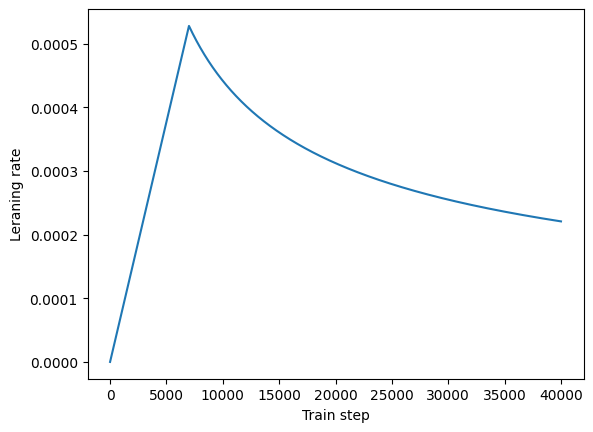

In [28]:
# 例子：下面是学习率的设计图
plt.plot(temp_learning_rate_schedule(np.arange(0, 40000)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")
plt.show()

### 优化器

In [29]:
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Adam

def get_optimizer(model, config):
    base_lr = 0.1
    beta1 = config["beta1"]  # Adam 的 beta1
    beta2 = config["beta2"]  # Adam 的 beta2
    eps = config["eps"]

    # 初始化Adam优化器
    optimizer = Adam(model.parameters(), lr=base_lr, betas=(beta1, beta2), eps=eps)

    # 初始化学习率调度器
    lr_scheduler = NoamDecayScheduler(config)

    # 使用 LambdaLR 调度器调整学习率
    scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler)

    return optimizer, scheduler

### Callback

In [30]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [31]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [32]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


### Training and Evaluation

In [33]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for batch in dataloader:
        encoder_inputs = batch["encoder_inputs"]
        encoder_inputs_mask = batch["encoder_inputs_mask"]
        decoder_inputs = batch["decoder_inputs"]
        decoder_labels = batch["decoder_labels"]
        decoder_labels_mask = batch["decoder_labels_mask"]

        # 前向计算
        outputs = model(
            encoder_inputs=encoder_inputs,
            decoder_inputs=decoder_inputs,
            encoder_inputs_mask=encoder_inputs_mask
        )
        logits = outputs.logits

        # 计算损失
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)
        loss_list.append(loss.cpu().item())

    return np.mean(loss_list)  # 返回平均损失

In [34]:
# 训练
def training(
    model,
    train_dl,
    val_dl,
    epoch,
    loss_fct,
    optimizer,
    scheduler=None,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    val_loss = 0.0
    global_step = 1
    model.train()
    with tqdm(total=epoch * len(train_dl)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_dl:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]
                # 梯度清空
                optimizer.zero_grad()

                # 前向计算
                outputs = model(
                    encoder_inputs=encoder_inputs,
                    decoder_inputs=decoder_inputs,
                    encoder_inputs_mask=encoder_inputs_mask
                    )
                logits = outputs.logits
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()
                if scheduler is not None:
                    scheduler.step() # 更新学习率

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_dl, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    cur_lr = optimizer.param_groups[0]["lr"] if scheduler is None else scheduler.get_last_lr()[0]
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            lr=cur_lr,
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
            pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss})

    return record_dict

### Config

In [35]:
# 配置模型的超参数
config = {
    "bos_idx": 1,  # 句子起始标记 (Beginning of Sentence)
    "eos_idx": 3,  # 句子结束标记 (End of Sentence)
    "pad_idx": 0,  # 填充标记 (Padding Index)
    "en_vocab_size": len(en_word2idx),  # 英文词表大小
    "zh_vocab_size": len(zh_word2idx),  # 中文词表大小
    "max_length": 128,  # 句子最大长度
    "d_model": 512,  # Transformer 词向量的维度
    "dim_feedforward": 2048,  # 前馈神经网络（FFN）的隐藏层大小
    "dropout": 0.1,  # dropout 率，用于防止过拟合
    "layer_norm_eps": 1e-6,  # 层归一化 (Layer Normalization) 时的 epsilon，防止除零错误
    "num_heads": 8,  # 多头注意力机制的头数
    "num_decoder_layers": 6,  # 解码器层数
    "num_encoder_layers": 6,  # 编码器层数
    "label_smoothing": 0.1,  # 交叉熵损失中的标签平滑系数
    "beta1": 0.9,  # Adam 优化器的 beta1 参数（用于一阶矩估计）
    "beta2": 0.98,  # Adam 优化器的 beta2 参数（用于二阶矩估计）
    "eps": 1e-9,  # Adam 优化器的 epsilon，防止除零错误
    "warmup_steps": 4000,  # 学习率预热步数
    # "share_embedding": False,  # 是否在编码器和解码器之间共享词向量
}

def get_dl(dataset, batch_size, shuffle=True):
    """
    获取数据加载器 (DataLoader)

    参数：
    dataset: 训练或验证数据集
    batch_size: 批次大小
    shuffle: 是否对批次进行随机排序（默认 True）

    返回：
    DataLoader 对象
    """
    # 使用 Transformer 任务自定义的批次采样器，确保 batch 内的句子长度一致
    sampler = TransformerBatchSampler(dataset, batch_size=batch_size, shuffle_batch=shuffle)
    # 使用 DataLoader 进行数据加载，collate_fn 用于处理不同长度的句子
    sample_dl = DataLoader(dataset, batch_sampler=sampler, collate_fn=partial(collate_fct, en_tokenizer=en_tokenizer, zh_tokenizer=zh_tokenizer))
    return sample_dl

# 构建训练集和验证集
train_ds = LangPairDataset("train", max_length=config["max_length"])  # 训练数据集
val_ds = LangPairDataset("val", max_length=config["max_length"])  # 验证数据集

# 训练的批次大小
batch_size = 8192

# 创建数据加载器
train_dl = get_dl(train_ds, batch_size=batch_size, shuffle=True)  # 训练数据加载器
val_dl = get_dl(val_ds, batch_size=batch_size, shuffle=False)  # 验证数据加载器

load train dataset from train_data_size_1000000\.cache\de2en_train_128.npy
load val dataset from train_data_size_1000000\.cache\de2en_val_128.npy


In [36]:
import json
import os
# 指定目录
save_dir = "./checkpoints/model_bpe_50000_large_epoch40_not_share"
os.makedirs(save_dir, exist_ok=True)

# 保存路径
config_file_path = os.path.join(save_dir, "Config.txt")

# 将 config 字典写入文件
with open(config_file_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=4)

print(f"Config has been saved to {config_file_path}")

Config has been saved to ./checkpoints/model_bpe_50000_large_epoch40_not_share\Config.txt


In [37]:
#计算模型参数量
model = TransformerModel(config)
print(f"模型参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

模型参数量: 124844238


In [38]:
epoch = 1

# 初始化模型
model = TransformerModel(config)

# 定义损失函数，采用交叉熵损失
loss_fct = CrossEntropyWithPadding(config)

# 定义优化器和学习率调度器，采用 Adam 优化器
optimizer, scheduler = get_optimizer(model, config)

# 创建 tensorboard 可视化目录
if not os.path.exists("runs"):
    os.mkdir("runs")

# exp_name
exp_name = "model_bpe_50000_large_epoch40_not_share"
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")

# 创建保存检查点的目录
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/{exp_name}", save_step=500, save_best_only=True)

# 早停机制
early_stop_callback = EarlyStopCallback(patience=8)

# 将模型转移到设备
model = model.to(device)

### 开始训练

In [39]:
record = training(
    model,
    train_dl,
    val_dl,
    epoch,
    loss_fct,
    optimizer,
    scheduler,
    tensorboard_callback= tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=500
    )

 ### 损失率折线图

In [40]:
import matplotlib.pyplot as plt
train_losses = [item['loss'] for item in record['train']]
train_steps = [item['step'] for item in record['train']]
val_losses = [item['loss'] for item in record['val']]
val_steps = [item['step'] for item in record['val']]

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(val_steps, val_losses, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# for item in record['val']:
#     print(item)

## 推理

### 加载模型

In [42]:
import torch

state_dict = torch.load(f"./checkpoints/{exp_name}/best.ckpt", map_location="cpu", weights_only=True)

# 加载 Transformer 模型
model = TransformerModel(config)  # 初始化 Transformer 模型
model.load_state_dict(state_dict)  # 加载预训练模型的参数

<All keys matched successfully>

### 计算 BLEU 评分

In [43]:
# ! pip install sacremoses
# ! pip install subword-nmt

In [44]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
from rouge_score import rouge_scorer
# 定义损失函数（交叉熵损失，带有标签平滑）
loss_fct = CrossEntropyWithPadding(config)

# 加载测试数据集
test_ds = LangPairDataset("test", max_length=128, data_dir=f"./{dataset_path}")  # 测试数据集
test_dl = DataLoader(test_ds, batch_size=1, collate_fn=partial(collate_fct, en_tokenizer=en_tokenizer, zh_tokenizer=zh_tokenizer))  # 数据加载器

# 迁移模型到计算设备（CPU/GPU）
model = model.to(device)
model.eval()  # 设置模型为评估模式，防止 dropout 或 batchnorm 影响推理

# 创建平滑函数实例
smoothing_function = SmoothingFunction().method1  # 使用method1平滑

# 定义数据收集字典
collect = {}  # 用于存储测试集中的样本及其损失
loss_collect = []  # 用于收集所有样本的损失

predictions = []  # 存储所有预测结果
answers = []  # 存储所有真实标签
bleu1_scores = []  # 存储 BLEU-1 评分
bleu2_scores = []  # 存储 BLEU-2 评分
bleu3_scores = []  # 存储 BLEU-3 评分
bleu4_scores = []  # 存储 BLEU-4 评分

# 定义 ROUGE 评分器
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# 存储 ROUGE 评分
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# 遍历测试集
for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl), desc="Evaluating", unit="batch"):
    encoder_inputs = batch["encoder_inputs"]  # 编码器输入（源语言）
    encoder_inputs_mask = batch["encoder_inputs_mask"]  # 源输入的填充掩码
    decoder_inputs = batch["decoder_inputs"]  # 解码器输入（目标语言）
    decoder_labels = batch["decoder_labels"]  # 目标真实标签（用于计算损失）

    # 进行前向传播，获取 Transformer 输出
    outputs = model(
        encoder_inputs=encoder_inputs,
        decoder_inputs=decoder_inputs,
        encoder_inputs_mask=encoder_inputs_mask
    )

    # 计算交叉熵损失
    loss = loss_fct(outputs.logits, decoder_labels)

    # 获取预测结果：取每个时间步上最大概率的词索引
    preds = outputs.logits.argmax(dim=-1)  # 预测序列形状为 [1, seq_len]

    # 将预测索引转换为实际的文本句子
    preds = zh_tokenizer.decode(preds.cpu().numpy())  # ['预测句子']

    # 将真实标签转换为文本句子
    decoder_labels = zh_tokenizer.decode(decoder_labels.cpu().numpy())  # ['标签句子']

    # 计算不同n-gram的BLEU评分
    bleu1 = sentence_bleu([decoder_labels[0].split()], preds[0].split(), weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
    bleu2 = sentence_bleu([decoder_labels[0].split()], preds[0].split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    bleu3 = sentence_bleu([decoder_labels[0].split()], preds[0].split(), weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
    bleu4 = sentence_bleu([decoder_labels[0].split()], preds[0].split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

    bleu1_scores.append(bleu1)  # 存储 BLEU-1 分数
    bleu2_scores.append(bleu2)  # 存储 BLEU-2 分数
    bleu3_scores.append(bleu3)  # 存储 BLEU-3 分数
    bleu4_scores.append(bleu4)  # 存储 BLEU-4 分数

    # 计算 ROUGE 评分
    rouge_scores = rouge_scorer.score(decoder_labels[0], preds[0])
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    # 记录样本信息，包括损失、输入、目标、预测
    collect[idx] = {
        "loss": loss.item(),  # 当前样本的损失
        "src_inputs": encoder_inputs,  # 源语言输入
        "trg_inputs": decoder_inputs,  # 目标语言输入
        "mask": encoder_inputs_mask,  # 源语言的填充掩码
        "trg_labels": decoder_labels,  # 真实目标文本
        "preds": preds  # 预测文本
    }

    # 记录损失
    loss_collect.append(loss.item())

# 按照损失大小对收集的数据进行排序（从低到高）
collect = sorted(collect.items(), key=lambda x: x[1]["loss"])

# 输出测试集平均损失
print(f"testing loss: {np.array(loss_collect).mean()}")

# 输出各个n-gram BLEU评分的平均值
print(f"Average BLEU-1 score: {sum(bleu1_scores) / len(bleu1_scores)}")
print(f"Average BLEU-2 score: {sum(bleu2_scores) / len(bleu2_scores)}")
print(f"Average BLEU-3 score: {sum(bleu3_scores) / len(bleu3_scores)}")
print(f"Average BLEU-4 score: {sum(bleu4_scores) / len(bleu4_scores)}")
# 输出 ROUGE 评分
print(f"Average ROUGE-1 score: {sum(rouge1_scores) / len(rouge1_scores)}")
print(f"Average ROUGE-2 score: {sum(rouge2_scores) / len(rouge2_scores)}")
print(f"Average ROUGE-L score: {sum(rougeL_scores) / len(rougeL_scores)}")

### Translating

In [45]:
import re
import torch
import matplotlib.pyplot as plt
import matplotlib
from sacremoses import MosesDetokenizer, MosesTokenizer
from pathlib import Path
import subprocess


class Translator:
    def __init__(self, model, en_tokenizer, zh_tokenizer, dataset_path="./train_data_size_1000000"):
        self.dataset_path = Path(dataset_path)
        self.en_bpe_rules = self.dataset_path / "bpe.en.50000"
        self.zh_bpe_rules = self.dataset_path / "bpe.zh.50000"
        self.en_vocab = self.dataset_path / "en.vocab"
        self.zh_vocab = self.dataset_path / "zh.vocab"

        self.mose_tokenizer = MosesTokenizer(lang="en")
        self.mose_detokenizer = MosesDetokenizer(lang="zh")

        self.model = model
        self.model.eval()

        self.en_tokenizer = en_tokenizer
        self.zh_tokenizer = zh_tokenizer

        self.pattern = re.compile(r'(@@ )|(@@ ?$)')

    def apply_bpe(self, input_file, output_file, bpe_rules, vocab_file):
        try:
            subprocess.run([
                "subword-nmt", "apply-bpe",
                "-c", str(bpe_rules),
                "--vocabulary", str(vocab_file),
                "--vocabulary-threshold", "50",
                "-i", str(input_file),
                "-o", str(output_file)
            ], check=True)
        except subprocess.CalledProcessError as e:
            raise RuntimeError(f"Failed to apply BPE: {e}")

    def draw_attention_map(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list, idx=0):
        """
        绘制注意力图并保存为高质量 PNG 文件，使用 viridis 色图增强对比度。
        """
        matplotlib.rcParams['font.sans-serif'] = ['SimHei']
        matplotlib.rcParams['axes.unicode_minus'] = False

        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]

        num_heads, trg_len, src_len = cross_attn_scores.shape

        fig = plt.figure(figsize=(12, 8), dpi=300, facecolor='white', constrained_layout=True)
        grid = fig.add_gridspec(trg_len, trg_len + src_len, wspace=0.1, hspace=0.1)

        # 自注意力图
        self_map = fig.add_subplot(grid[:, :trg_len])
        self_map.matshow(attn_scores.mean(dim=0), cmap='viridis', vmin=0.0, vmax=1.0)
        self_map.set_facecolor('#f0f0f0')
        self_map.set_title("Self-Attention", fontsize=10)
        self_map.set_xticks(range(trg_len))
        self_map.set_xticklabels(["[BOS]"] + trg_words_list[:-1], fontsize=8, rotation=90)
        self_map.set_yticks(range(trg_len))
        self_map.set_yticklabels(trg_words_list, fontsize=8)
        self_map.set_xlabel("Key", fontsize=9)
        self_map.set_ylabel("Query", fontsize=9)

        # 交叉注意力图
        cross_map = fig.add_subplot(grid[:, trg_len:])
        cross_map.matshow(cross_attn_scores.mean(dim=0), cmap='viridis', vmin=0.0, vmax=1.0)
        cross_map.set_facecolor('#f0f0f0')
        cross_map.set_title("Cross-Attention", fontsize=10)
        cross_map.set_xticks(range(src_len))
        cross_map.set_xticklabels(src_words_list, fontsize=8, rotation=90)
        cross_map.set_yticks(range(trg_len))
        cross_map.set_yticklabels([])  # 避免重复
        cross_map.set_xlabel("Encoder Key", fontsize=9)

        # 保存高清 PNG 文件
        save_path = f"attention_map_{idx}.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
        print(f"[✓] Saved attention map: {save_path}")

    def __call__(self, sentence_list, heads_list=None, layer_idx=-1):
        """
        执行翻译并绘制注意力图。
        """
        sentence_list = [" ".join(self.mose_tokenizer.tokenize(s.lower())) for s in sentence_list]

        temp_input_file = self.dataset_path / "temp_input.txt"
        temp_output_file = self.dataset_path / "temp_output.bpe"

        with open(temp_input_file, "w", encoding="utf8") as f:
            f.write("\n".join(sentence_list))

        self.apply_bpe(temp_input_file, temp_output_file, self.en_bpe_rules, self.en_vocab)

        with open(temp_output_file, "r", encoding="utf8") as f:
            en_tokens_list = [line.strip().split() for line in f]
        print(en_tokens_list)
        encoder_input, attn_mask = self.en_tokenizer.encode(
            en_tokens_list, add_bos=True, add_eos=True, return_mask=True
        )
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)

        outputs = self.model.infer(encoder_inputs=encoder_input, encoder_inputs_mask=attn_mask)
        preds = outputs.preds.numpy()

        attn_scores = outputs.decoder_self_attn_scores[layer_idx]
        cross_attn_scores = outputs.decoder_cross_attn_scores[layer_idx]

        trg_decoded = self.zh_tokenizer.decode(
            preds, split=True, remove_eos=False, remove_bos=False, remove_pad=False
        )
        src_decoded = self.en_tokenizer.decode(
            encoder_input.numpy(), split=True, remove_bos=False, remove_eos=False
        )

        for idx, (attn_score, cross_attn_score, src, trg) in enumerate(zip(attn_scores, cross_attn_scores, src_decoded, trg_decoded)):
            self.draw_attention_map(attn_score, cross_attn_score, src, trg, idx=idx)

        return [self.mose_detokenizer.tokenize(self.pattern.sub("", s).split()) for s in self.zh_tokenizer.decode(preds)]


#示例调用（前提是模型、tokenizer 等已初始化）
sentence_list = ["The United Nations held an international meeting on human rights."]
model = TransformerModel(config)
model.load_state_dict(state_dict)
translator = Translator(model.cpu(), en_tokenizer, zh_tokenizer)
translated_sentences = translator(sentence_list, layer_idx=-1)
for sentence in translated_sentences:
    print("Translated sentence:", sentence)


[['the', 'united', 'nations', 'held', 'an', 'international', 'meeting', 'on', 'human', 'rights', '.']]


  0%|          | 0/128 [00:00<?, ?it/s]

[✓] Saved attention map: attention_map_0.png
Translated sentence: 联合国举行了一次人权会议。


In [51]:
import re
import torch
import matplotlib.pyplot as plt
import matplotlib
from sacremoses import MosesDetokenizer, MosesTokenizer
from pathlib import Path
import subprocess


class Translator:
    def __init__(self, model, en_tokenizer, zh_tokenizer, dataset_path="./train_data_size_1000000"):
        self.dataset_path = Path(dataset_path)
        self.en_bpe_rules = self.dataset_path / "bpe.en.50000"
        self.zh_bpe_rules = self.dataset_path / "bpe.zh.50000"
        self.en_vocab = self.dataset_path / "en.vocab"
        self.zh_vocab = self.dataset_path / "zh.vocab"

        self.mose_tokenizer = MosesTokenizer(lang="en")
        self.mose_detokenizer = MosesDetokenizer(lang="zh")

        self.model = model
        self.model.eval()

        self.en_tokenizer = en_tokenizer
        self.zh_tokenizer = zh_tokenizer

        self.pattern = re.compile(r'(@@ )|(@@ ?$)')

    def apply_bpe(self, input_file, output_file, bpe_rules, vocab_file):
        try:
            subprocess.run([
                "subword-nmt", "apply-bpe",
                "-c", str(bpe_rules),
                "--vocabulary", str(vocab_file),
                "--vocabulary-threshold", "50",
                "-i", str(input_file),
                "-o", str(output_file)
            ], check=True)
        except subprocess.CalledProcessError as e:
            raise RuntimeError(f"Failed to apply BPE: {e}")
       
    def draw_attention_map(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list, idx=0):
        """
        绘制注意力图并保存为高质量 PNG 文件，标注每个格子的注意力分数。
        """
        import numpy as np
        matplotlib.rcParams['font.sans-serif'] = ['SimHei']
        matplotlib.rcParams['axes.unicode_minus'] = False

        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]

        num_heads, trg_len, src_len = cross_attn_scores.shape

        fig = plt.figure(figsize=(12, 8), dpi=300, facecolor='white', constrained_layout=True)
        grid = fig.add_gridspec(trg_len, trg_len + src_len, wspace=0.05, hspace=0.1)

        # 自注意力图
        self_map = fig.add_subplot(grid[:, :trg_len])
        self_avg = attn_scores.mean(dim=0).numpy()
        im1 = self_map.matshow(self_avg, cmap='viridis', vmin=0.0, vmax=1.0)
        self_map.set_facecolor('#f0f0f0')
        self_map.set_title("Self-Attention", fontsize=14, fontweight='bold')
        self_map.set_xticks(range(trg_len))
        self_map.set_xticklabels(["[BOS]"] + trg_words_list[:-1], fontsize=11, rotation=90, fontweight='bold')
        self_map.set_yticks(range(trg_len))
        self_map.set_yticklabels(trg_words_list, fontsize=11, fontweight='bold')
        self_map.set_xlabel("Key", fontsize=12, fontweight='bold')
        self_map.set_ylabel("Query", fontsize=12, fontweight='bold')

        # 给每个格子添加注意力值
        for y in range(trg_len):
            for x in range(trg_len):
                val = self_avg[y, x]
                color = 'white' if val > 0.5 else 'black'
                self_map.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=7, color=color)

        # 交叉注意力图
        cross_map = fig.add_subplot(grid[:, trg_len:])
        cross_avg = cross_attn_scores.mean(dim=0).numpy()
        im2 = cross_map.matshow(cross_avg, cmap='viridis', vmin=0.0, vmax=1.0)
        cross_map.set_facecolor('#f0f0f0')
        cross_map.set_title("Cross-Attention", fontsize=14, fontweight='bold')
        cross_map.set_xticks(range(src_len))
        cross_map.set_xticklabels(src_words_list, fontsize=11, rotation=90, fontweight='bold')
        cross_map.set_yticks(range(trg_len))
        cross_map.set_yticklabels([])  # 避免重复
        cross_map.set_xlabel("Encoder Key", fontsize=12, fontweight='bold')

        for y in range(trg_len):
            for x in range(src_len):
                val = cross_avg[y, x]
                color = 'white' if val > 0.5 else 'black'
                cross_map.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=7, color=color)

        # 保存高清图像
        save_path = f"attention_map_{idx}.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
        print(f"[✓] Saved attention map: {save_path}")

    def __call__(self, sentence_list, heads_list=None, layer_idx=-1):
        """
        执行翻译并绘制注意力图。
        """
        sentence_list = [" ".join(self.mose_tokenizer.tokenize(s.lower())) for s in sentence_list]
        print(sentence_list)
        temp_input_file = self.dataset_path / "temp_input.txt"
        temp_output_file = self.dataset_path / "temp_output.bpe"

        with open(temp_input_file, "w", encoding="utf8") as f:
            f.write("\n".join(sentence_list))

        self.apply_bpe(temp_input_file, temp_output_file, self.en_bpe_rules, self.en_vocab)

        with open(temp_output_file, "r", encoding="utf8") as f:
            en_tokens_list = [line.strip().split() for line in f]
        print(en_tokens_list)
        encoder_input, attn_mask = self.en_tokenizer.encode(
            en_tokens_list, add_bos=True, add_eos=True, return_mask=True
        )
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)

        outputs = self.model.infer(encoder_inputs=encoder_input, encoder_inputs_mask=attn_mask)
        preds = outputs.preds.numpy()

        attn_scores = outputs.decoder_self_attn_scores[layer_idx]
        cross_attn_scores = outputs.decoder_cross_attn_scores[layer_idx]

        trg_decoded = self.zh_tokenizer.decode(
            preds, split=True, remove_eos=False, remove_bos=False, remove_pad=False
        )
        src_decoded = self.en_tokenizer.decode(
            encoder_input.numpy(), split=True, remove_bos=False, remove_eos=False
        )

        for idx, (attn_score, cross_attn_score, src, trg) in enumerate(zip(attn_scores, cross_attn_scores, src_decoded, trg_decoded)):
            self.draw_attention_map(attn_score, cross_attn_score, src, trg, idx=idx)

        return [self.mose_detokenizer.tokenize(self.pattern.sub("", s).split()) for s in self.zh_tokenizer.decode(preds)]
#示例调用（前提是模型、tokenizer 等已初始化）
sentence_list = ['The annual climate summit will be held in Geneva next month.']
model = TransformerModel(config)
model.load_state_dict(state_dict)
translator = Translator(model.cpu(), en_tokenizer, zh_tokenizer)
translated_sentences = translator(sentence_list, layer_idx=-1)
for sentence in translated_sentences:
    print("Translated sentence:", sentence)

['the annual climate summit will be held in geneva next month .']
[['the', 'annual', 'climate', 'summit', 'will', 'be', 'held', 'in', 'geneva', 'next', 'month', '.']]


  0%|          | 0/128 [00:00<?, ?it/s]

[✓] Saved attention map: attention_map_0.png
Translated sentence: 年度气候首脑会议将于下一次在日内瓦举行。


In [47]:
import torch
import matplotlib.pyplot as plt
import os

# 示例输入（替换为你真实句子）
inputs_words = [
    "The United Nations held an international meeting on development and human rights.",
    "Access to information promotes effective management."
]

# 创建保存路径
save_dir = "sci_masks"
os.makedirs(save_dir, exist_ok=True)

# 分词器编码（需替换为你自己的 tokenizer）
inputs_ids, input_mask = en_tokenizer.encode(
    [w.split() for w in inputs_words], return_mask=True
)

# Look-ahead mask 构造
def generate_square_subsequent_mask(size):
    return torch.triu(torch.ones(size, size), diagonal=1).bool()

# 绘图主循环
for i in range(len(inputs_words)):
    decode_text = en_tokenizer.decode(
        inputs_ids[i: i+1].tolist(),
        remove_bos=False,
        remove_eos=False,
        remove_pad=False,
        split=True
    )[0]

    seq_len = inputs_ids.shape[-1]
    self_attn_mask = input_mask[i].reshape(1, -1).repeat_interleave(seq_len, dim=0)
    look_ahead_mask = generate_square_subsequent_mask(seq_len)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=300, facecolor='white')
    cmap = 'viridis'  # 推荐配色：高对比、科学期刊常见
    font_title = 14
    font_label = 12
    font_tick = 11
    font_grid = 7

    for ax, mask, title in zip(
        axs,
        [self_attn_mask, look_ahead_mask],
        ["Self-Attention Mask", "Look-Ahead Mask"]
    ):
        # 显示矩阵
        im = ax.matshow(mask, cmap=cmap)
        ax.set_title(title, fontsize=font_title, pad=12)
        ax.set_xticks(range(len(decode_text)))
        ax.set_yticks(range(len(decode_text)))
        ax.set_xticklabels(decode_text, rotation=90, fontsize=font_tick)
        ax.set_yticklabels(decode_text, fontsize=font_tick)
        ax.set_xlabel("Key Tokens", fontsize=font_label)
        ax.set_ylabel("Query Tokens", fontsize=font_label)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_facecolor("#f0f0f0")

        # 在每个格子中添加值
        mask_np = mask.numpy()
        for y in range(mask_np.shape[0]):
            for x in range(mask_np.shape[1]):
                val = int(mask_np[y, x])
                color = "white" if val > 0.5 else "black"
                ax.text(x, y, str(val), ha='center', va='center', color=color, fontsize=font_grid)

    # 自动排版 + 保存为高清图
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"mask_{i}.png"), bbox_inches='tight', dpi=300)
    plt.savefig(os.path.join(save_dir, f"mask_{i}.pdf"), bbox_inches='tight', dpi=300)  # PDF 适合嵌入 LaTeX
    plt.close()

    print(f"[✓] Saved mask_{i}.png and mask_{i}.pdf")


[✓] Saved mask_0.png and mask_0.pdf
[✓] Saved mask_1.png and mask_1.pdf


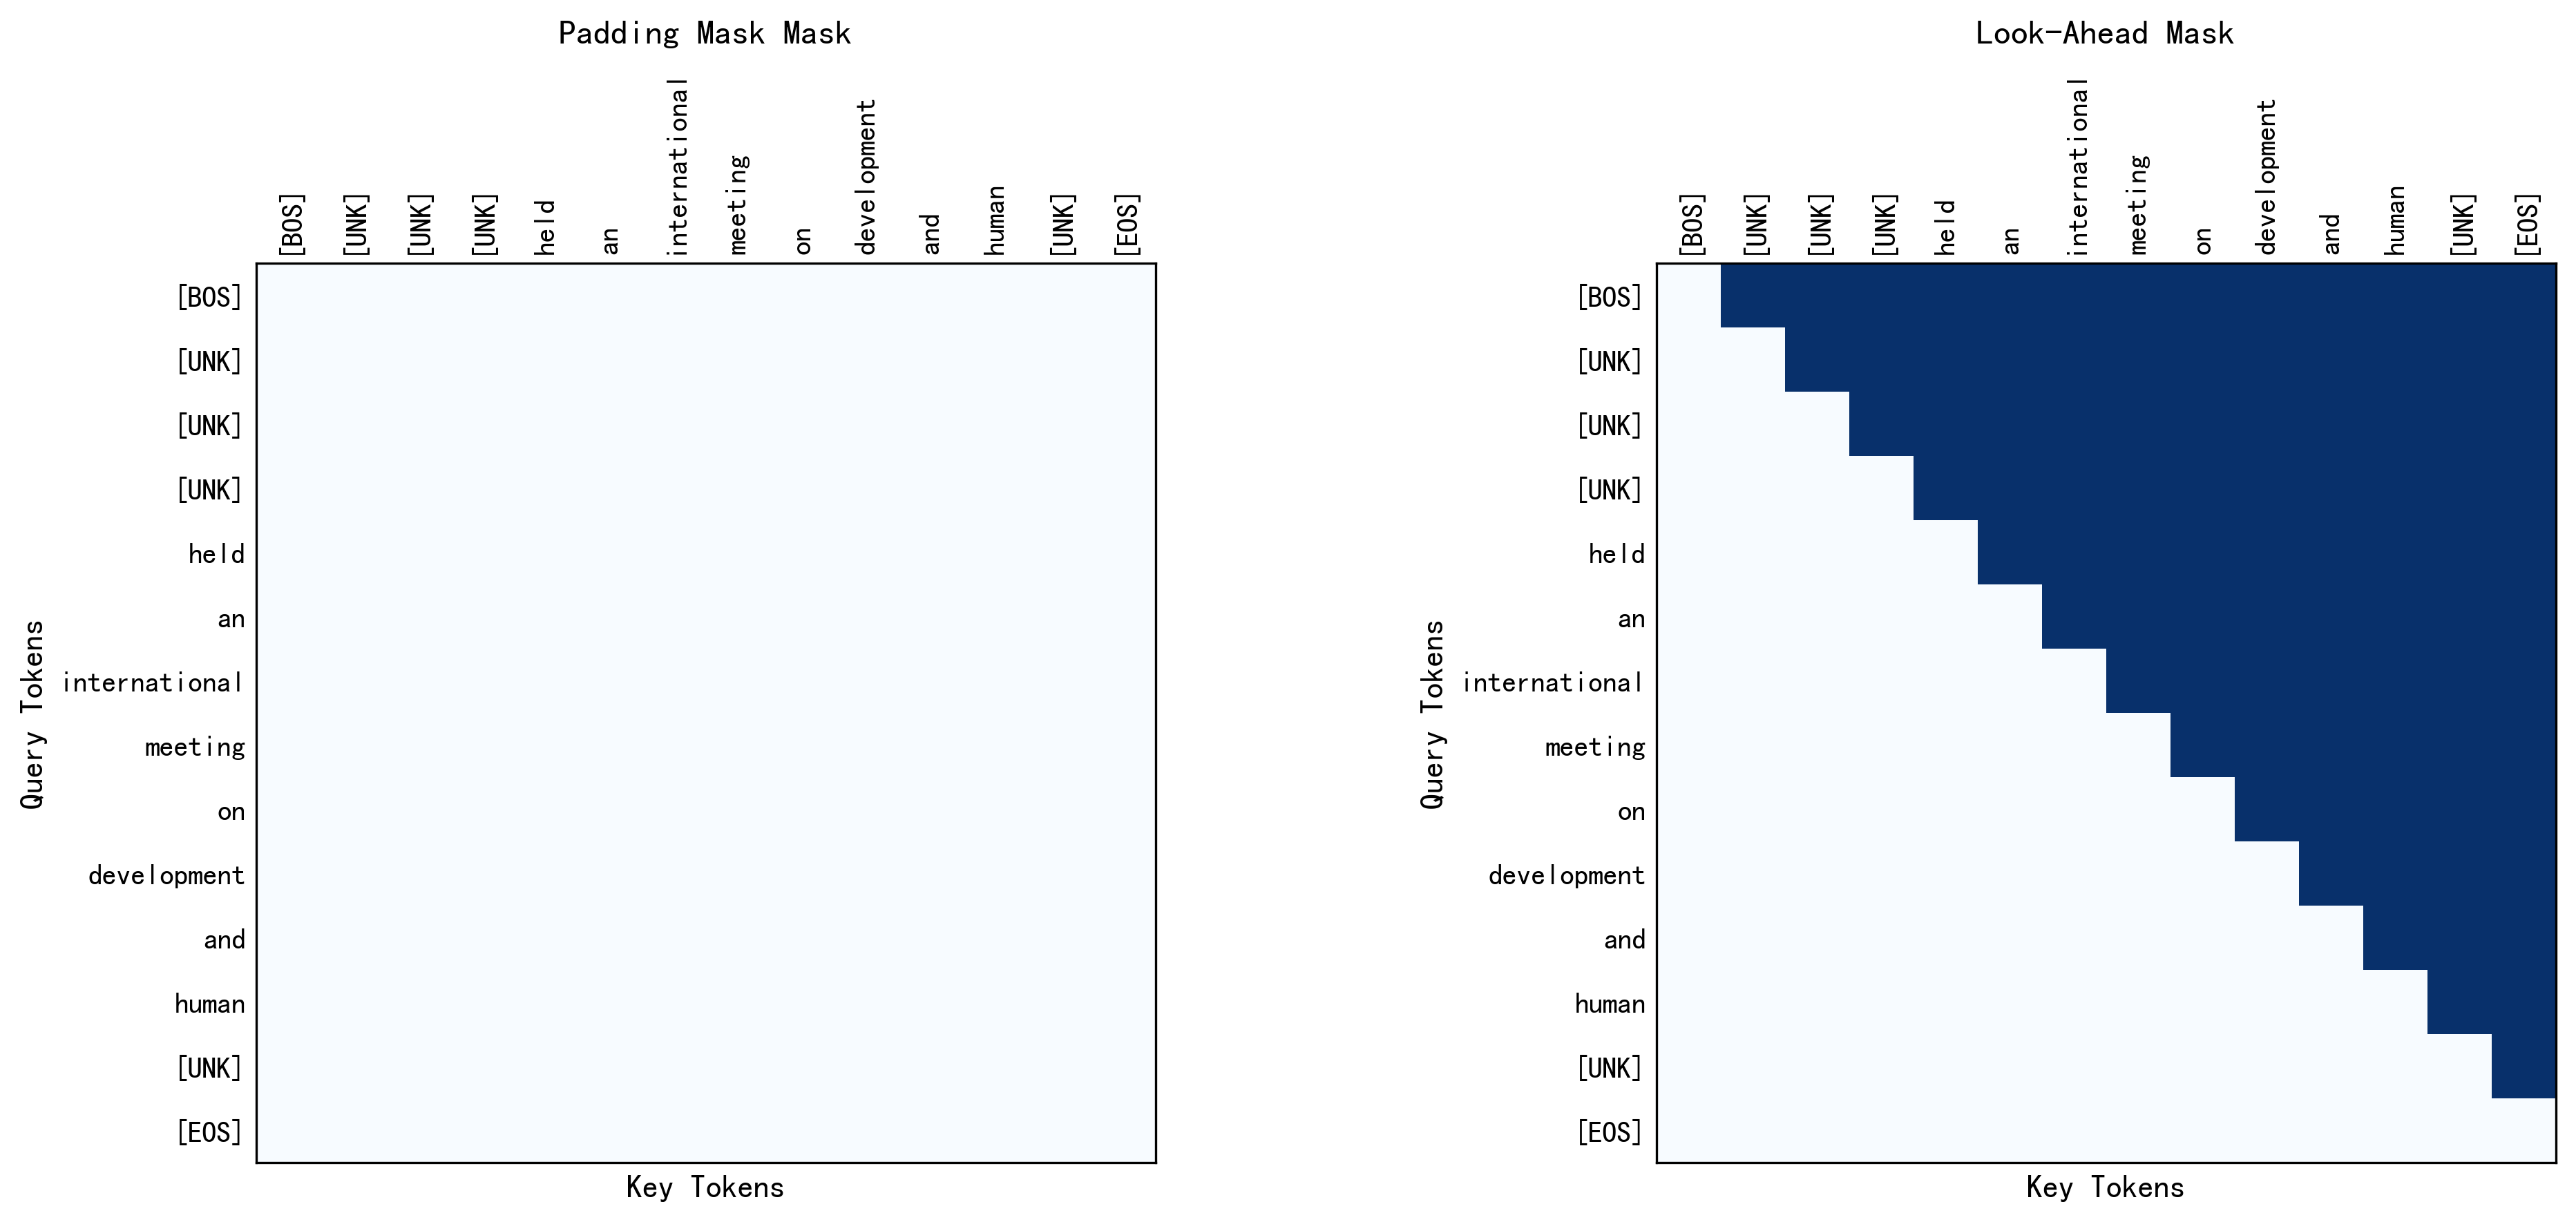

Saved figure to: mask_outputs\mask_vis_0.png


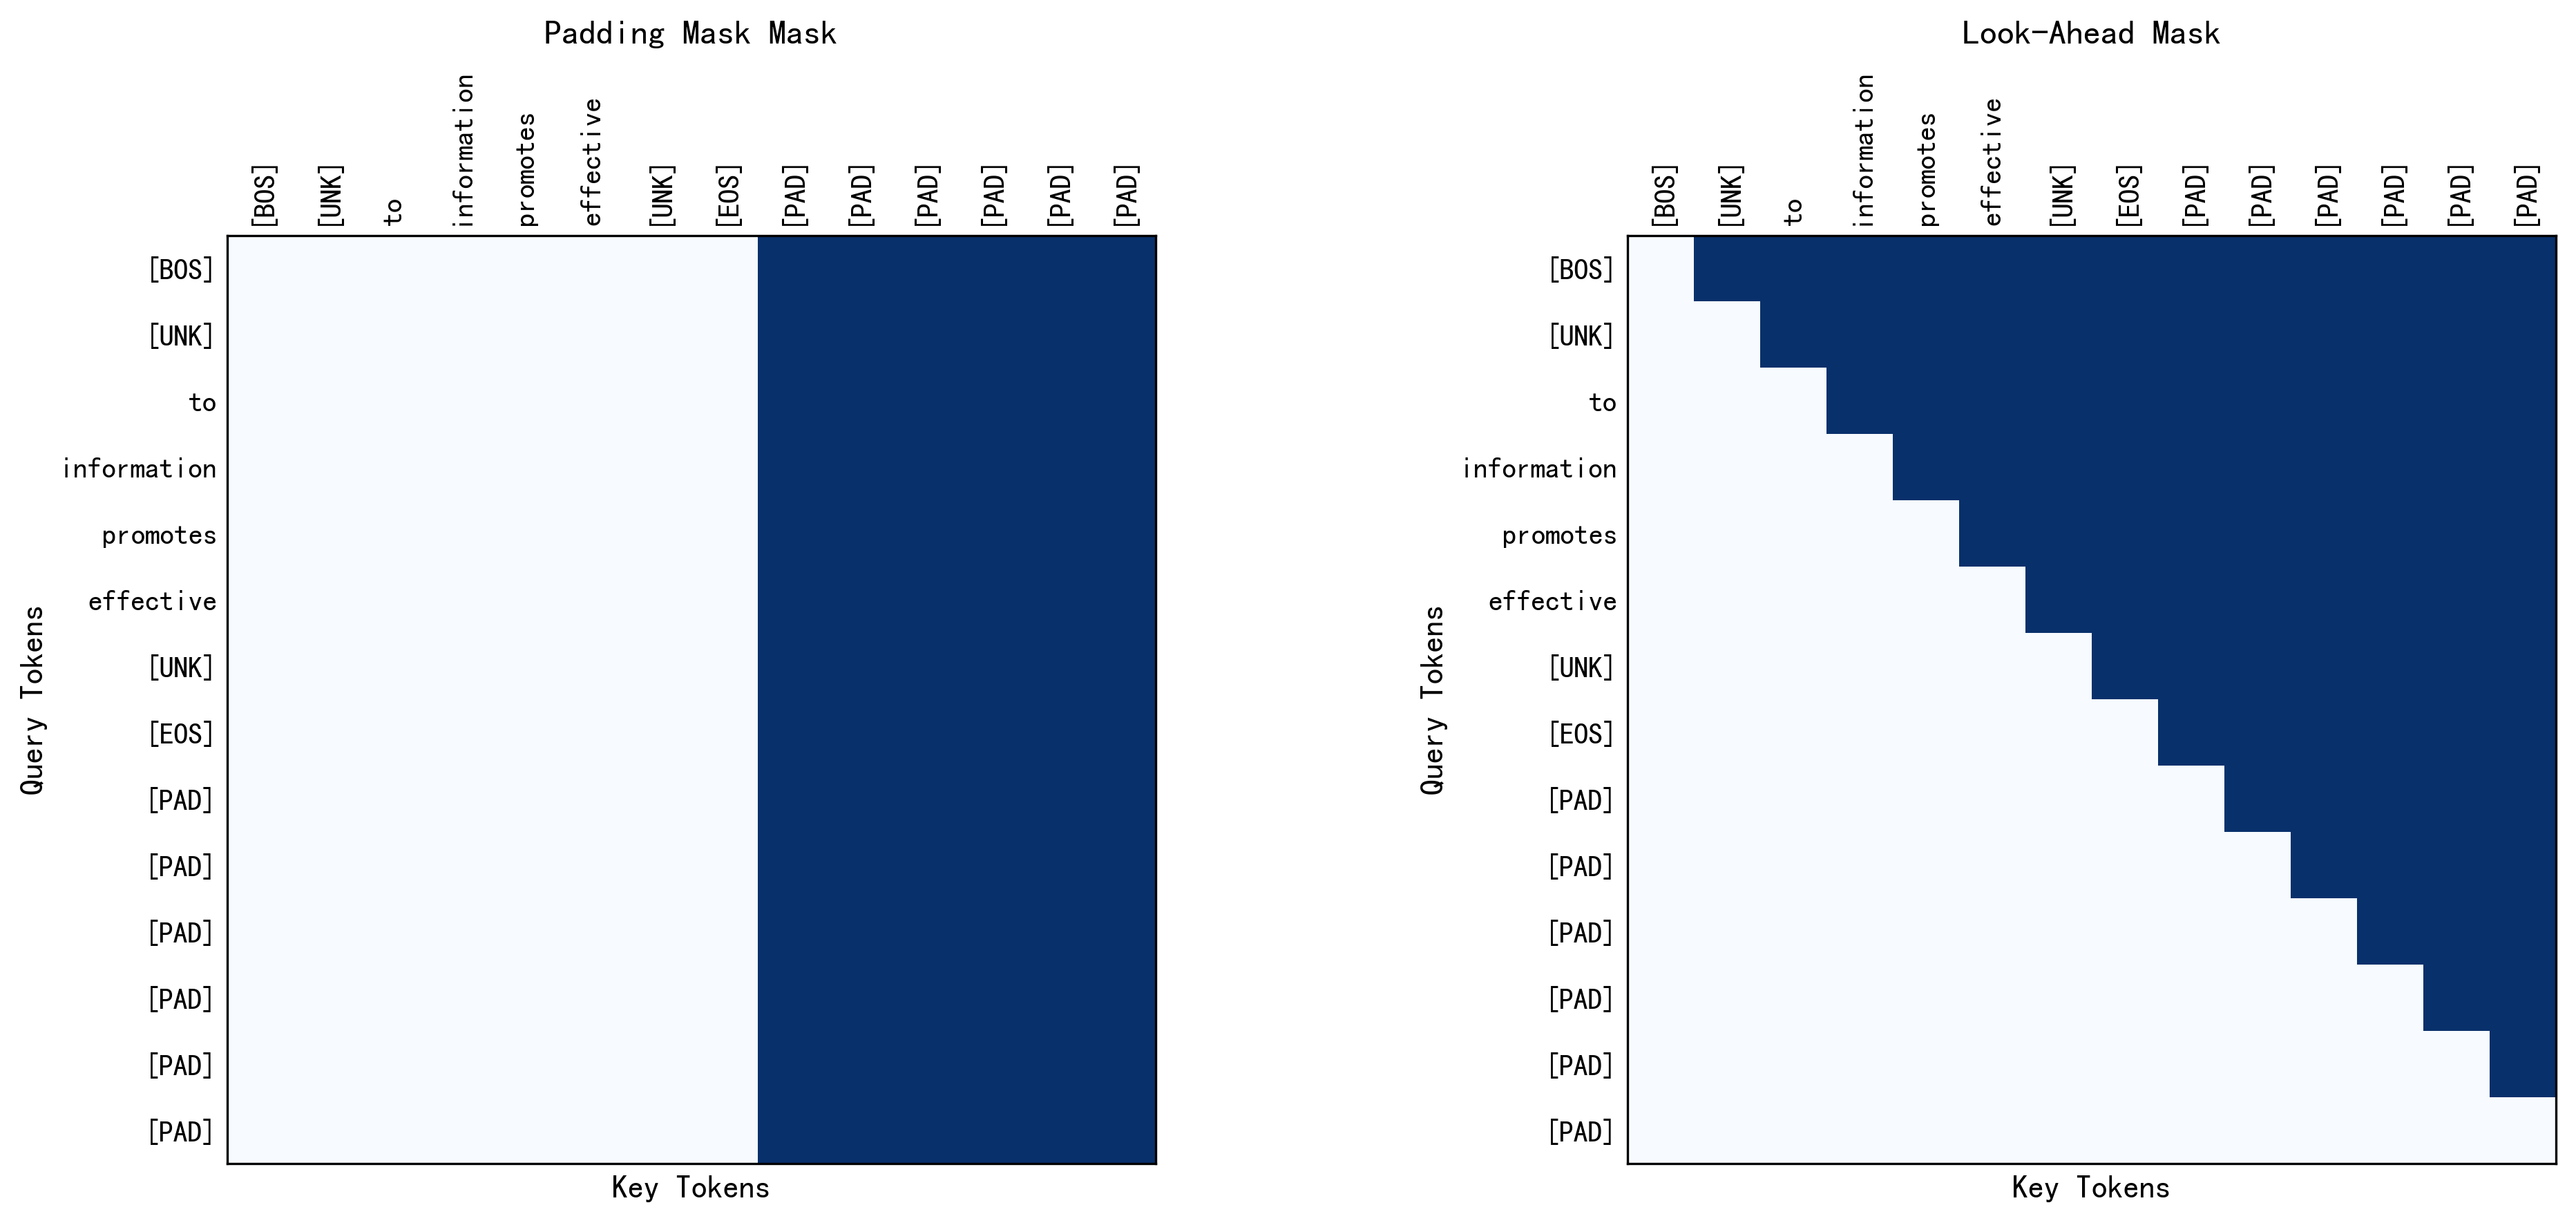

Saved figure to: mask_outputs\mask_vis_1.png


In [48]:
import torch
import matplotlib.pyplot as plt
import os

# 示例输入（替换为你真实使用的句子）
inputs_words = [
    "The United Nations held an international meeting on development and human rights.",
    "Access to information promotes effective management."
]

# 编码及mask生成（你已有的分词器）
inputs_ids, input_mask = en_tokenizer.encode(
    [w.split() for w in inputs_words], return_mask=True
)

# 生成look-ahead mask的函数
def generate_square_subsequent_mask(size):
    return torch.triu(torch.ones(size, size), diagonal=1).bool()

# 创建保存路径（可修改）
save_dir = "mask_outputs"
os.makedirs(save_dir, exist_ok=True)

# 遍历每个样本，绘制并保存图像
for i in range(len(inputs_words)):
    decode_text = en_tokenizer.decode(
        inputs_ids[i: i+1].tolist(),
        remove_bos=False,
        remove_eos=False,
        remove_pad=False,
        split=True
    )[0]

    self_attn_mask = input_mask[i].reshape(1, -1).repeat_interleave(inputs_ids.shape[-1], dim=0)
    look_ahead_mask = generate_square_subsequent_mask(inputs_ids.shape[-1])

    # 绘图区域
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=300, facecolor='white')
    plt.subplots_adjust(wspace=0.05)
    cmap = 'Blues'  # 可选色系：'Greens', 'coolwarm', 'RdBu'...

    for ax, mask, title in zip(
        axs,
        [self_attn_mask, look_ahead_mask],
        ["Padding Mask Mask", "Look-Ahead Mask"]
    ):
        im = ax.matshow(mask, cmap=cmap)

        # ACL/EMNLP 风格：灰色背景坐标轴
        ax.set_facecolor("#f0f0f0")

        ax.set_title(title, fontsize=12, pad=8, fontweight='bold')
        ax.set_xticks(range(len(decode_text)))
        ax.set_yticks(range(len(decode_text)))
        ax.set_xticklabels(decode_text, rotation=90, fontsize=10)
        ax.set_yticklabels(decode_text, fontsize=10)
        ax.set_xlabel("Key Tokens", fontsize=11, fontweight='bold') 
        ax.set_ylabel("Query Tokens", fontsize=11, fontweight='bold')
        ax.tick_params(axis='both', which='both', length=0)

    plt.tight_layout()

    # 保存为高清 PNG 文件
    save_path = os.path.join(save_dir, f"mask_vis_{i}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()


    print(f"Saved figure to: {save_path}")
